In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from PIL import Image

from core.integrate import FeatureFusionScalableTSDFVolume
from core.dataset import ScanNet
from core.labeler import CLIPTextQuerier, KMeansLabeler

In [3]:
o3d._build_config["ENABLE_HEADLESS_RENDERING"]

True

In [4]:
scene = "scannet_scene0000_00"
save_dir = "/home/quanta/Experiments/feature-instance-fusion/" + scene + "/"

In [5]:
json_pth = os.path.abspath("../../config/views/" + scene + ".json")
with open(json_pth, "r") as f:
    views = json.load(f)['views']

In [6]:
tsdf_device = "cuda:1"
tsdf_volume = FeatureFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device="cuda:1",
)
tsdf_volume.load(save_dir + "tsdf/tsdf_volume_unpruned.pt")
verts = np.load(save_dir + "tsdf/verts.npy")
faces = np.load(save_dir + "tsdf/faces.npy")
tsdf_volume.load_feats(save_dir + "tsdf_feature_lseg/feats.pt")

In [7]:
verts_feats = tsdf_volume.extract_feat_on_grid(verts=verts, device='cpu')[0]

In [8]:
clip_querier = CLIPTextQuerier(device='cuda:1')
clip_querier.load_model()

In [24]:
scores = clip_querier.single_text_score(
    text="The door is near the refrigerator.",
    img_feats=torch.from_numpy(verts_feats),
)

<BarContainer object of 100 artists>

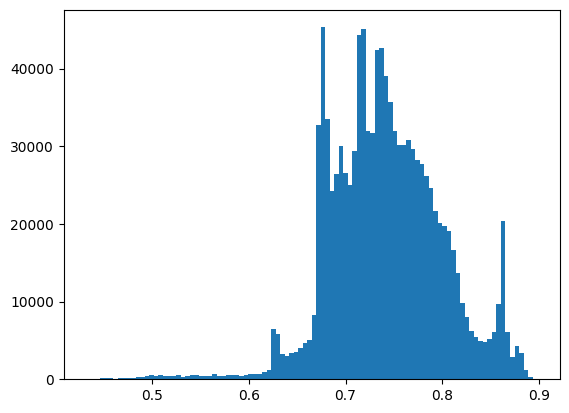

In [25]:
plt.hist(scores, bins=100)[2]

In [26]:
scores = np.clip(scores, 0.6, 1.0)
# scores = (scores - scores.min()) / (scores.max() - scores.min())

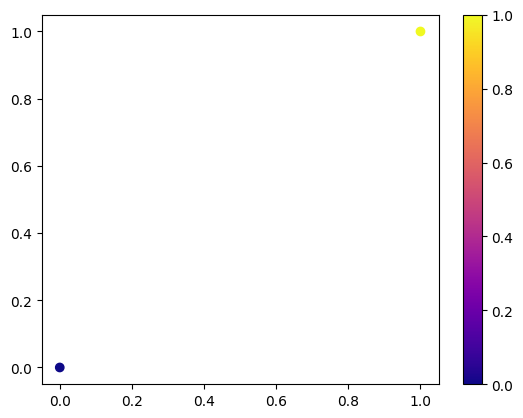

In [32]:
plt.scatter(x=[0, 1],y=[0, 1], c=[0, 1], cmap='plasma')
plt.colorbar()
plt.savefig('temp.pdf')

In [12]:
color = clip_querier.score_to_color(score=scores, scheme="jet", normalize=True)

In [13]:
mesh = o3d.geometry.TriangleMesh(
    vertices=o3d.utility.Vector3dVector(verts),
    triangles=o3d.utility.Vector3iVector(faces),
)
# mesh.compute_vertex_normals()
mesh.vertex_colors = o3d.utility.Vector3dVector(color)

In [14]:
save_dir = "../01_LSeg/03_single_word_similarity_plot/"
os.makedirs(save_dir, exist_ok=True)

In [15]:
for i, view in enumerate(views):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(mesh)
    vis.set_view_status(json.dumps(view["view"]))
    buffer = vis.capture_screen_float_buffer(do_render=True)
    image = Image.fromarray((np.asarray(buffer) * 255).astype(np.uint8))
    # display(image)
    image.save(save_dir + "{:02d}_".format(i) + view["tag"] + ".png")